In [2]:
%reset -f 
%matplotlib inline
import numpy as np
import os, sys, importlib, itertools
from datetime import datetime
import pandas as pd

# Import the aif module
pwd = os.path.abspath('') + "/"
sys.path.insert(1,pwd + '/aif_catkin_ws/aif_gazebo/scripts/')
import aif_functions_isobeliefs_convergent as aif

importlib.reload(aif)

<module 'aif_functions_isobeliefs_convergent' from 'c:\\Users\\qbr5kx\\OneDrive - University of Virginia\\Desktop\\UVA\\PhD Scratch\\Active_Epistemic_Inference\\aif_multi_robot//aif_catkin_ws/aif_gazebo/scripts\\aif_functions_isobeliefs_convergent.py'>

In [3]:
# Re-define the environment and simulation parameters here
interactive = True  # Set to True to display the animation in the notebook
args = {}
count = 0; flag_converged = True
draft_results = []
max_iterations = 50
convergence_type = 'converge'
list_types = ['A','B']
number_of_heading_options = 8; number_of_velocity_options = 4
env_size = 30  # Environment size
iterations_per_episode = 100  # Number of iterations per episode

while flag_converged and count < max_iterations:
    for use_ep in [True, False]:
        for greedy in [True, False]:
            if greedy and not use_ep:
                continue
            for num_agents in np.arange(2, 6, 1):
                for num_goals in np.arange(2, 6, 1):
                    random_seed = count  # Random seed 
                    np.random.seed(random_seed)  # Set random seed
                    goals = np.random.uniform(1,env_size-1,size=(num_goals, 2))  # Goal positions
                    agent_positions = np.hstack((np.random.uniform(0,env_size,size=(num_agents, 2)),np.zeros((num_agents,1))))  # Initial agent positions
                    # Set random goals
                    args = dict({
                    'goals': goals, # Goal positions
                    'agent_types': np.random.choice(list_types,num_agents), # Agent types
                    'home_base': np.array([0,0]), # Home base position
                    'agent_positions': agent_positions, # Initial agent positions
                    'velocity_options': np.linspace(0,1,number_of_velocity_options,endpoint=True), # Velocity options
                    'num_heading_options': number_of_heading_options, # Number of heading options
                    'heading_options': np.linspace(-np.pi,np.pi,number_of_heading_options,endpoint=True),
                    'observation_error_std': 0.5, # Observation error standard deviation
                    'num_actions': number_of_heading_options*number_of_velocity_options, # Number of actions
                    'env_size': env_size, # Environment size
                    'max_distance_measure': env_size + 20,
                    'max_heading_measure': np.pi, # Maximum heading measure
                    'prior': np.ones(goals.shape[0]) / goals.shape[0], # Prior belief
                    'use_ep': use_ep, # Use epistemic planning (2nd order reasoning)
                    'greedy': greedy, # Use greedy actions
                    'horizon': 5, # Horizon for free energy checking
                    'mcts_iterations': 100, # Number of MCTS iterations
                    'use_mcts': False,
                    'use_rhc': False, # Use receding horizon control
                    'use_threading': False, #TODO: Implement threading
                    'convergence_type': convergence_type, # Convergence type
                    'dt': 1.0, # Time step
                    })

                    # Check convergence for different types of conergence criterion
                    if args['convergence_type'] == 'exclusive':
                        tuple_elements = [i for i in range(goals.shape[0])]
                        configurations = list(itertools.permutations(tuple_elements))
                        args['reward_configs'] = configurations # Reward configurations if different goals
                    else:
                        args['reward_configs'] = [tuple(np.repeat(i, num_agents)) for i in range(num_goals)]
                    

                    # print("Initial Prior: ", args['prior'])

                    # Run the simulation
                    results = aif.run_simulation(args, iterations_per_episode)
                    # print("Final Prior: ", prior)
                    # print("Agent Types: ", args['agent_types'])

                    # energy_results, ending_energy = aif.parse_free_energy_scores(avg_nrg_over_time, num_frames)
                    draft_results.append([random_seed, results['converged'], num_goals, num_agents, args['agent_types'], 
                                        use_ep , greedy, results['iteration']])
    print("-------------------")
    print("\rPercentage Complete: ", count/max_iterations*100, "%", end="")
    print("-------------------")
    count += 1

# Save the results
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
df = pd.DataFrame(draft_results, columns=['seed','converged','num_goals','num_agents','agent_types','use_ep','greedy','num_iters'])    
df.to_csv(pwd + 'data/results_isobeliefs_envSize30_2-5Agents_numGoals2-5_WithUncertainty_Convergent{}.csv'.format(current_time), index=False)

Iteration 9: Agents have selected goals [0, 0]. Execution Time: 0.0010004043579101562s Agents have converged to Goal 0 after 9 iterations. Use EP: True
Iteration 100: Agents have selected goals [0, 1]. Execution Time: 0.0s Agents did not converge to the same goal within the maximum iterations.
Iteration 15: Agents have selected goals [1, 1]. Execution Time: 0.0009999275207519531s Agents have converged to Goal 1 after 15 iterations. Use EP: True
Iteration 100: Agents have selected goals [1, 3]. Execution Time: 0.0s Agents did not converge to the same goal within the maximum iterations.
Iteration 100: Agents have selected goals [0, 0, 1]. Execution Time: 0.00099945068359375s Agents did not converge to the same goal within the maximum iterations.
Iteration 100: Agents have selected goals [0, 1, 1]. Execution Time: 0.002000093460083008s Agents did not converge to the same goal within the maximum iterations.
Iteration 100: Agents have selected goals [1, 1, 3]. Execution Time: 0.000922679901

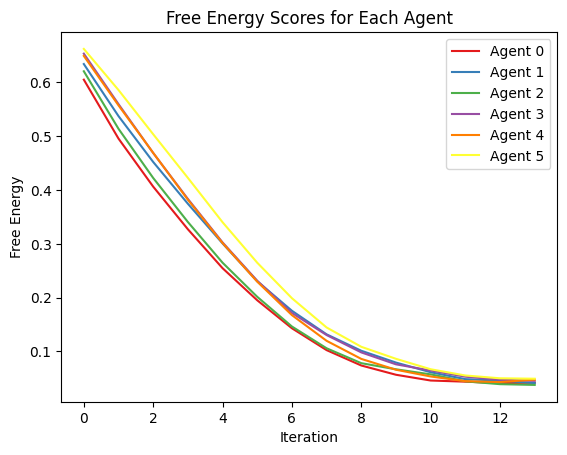

In [7]:
energy_results, ending_energy = aif.parse_free_energy_scores(avg_nrg_over_time, num_frames)
aif.plot_energy(energy_results, num_agents)

In [19]:
# Calculate distance to final goals
final_distances = np.zeros((num_agents, goals.shape[0]))
for i in range(num_agents):
    for j in range(goals.shape[0]):
        final_distances[i,j] = np.linalg.norm(final_positions[i,:2] - goals[j,:])
print("Final distances: ", final_distances)


Final distances:  [[0.02488646 9.98047395]
 [0.03748569 9.97078675]
 [0.09155599 9.99940493]]


In [20]:
# Scratch code for testing

goals = np.array([[0,0],[0.,10.]])
my_pose = np.array([14.12709979, 12.76192634,  0.])
other_pose = np.array([6.30305407,  7.28140647,  0.])
saliences = np.zeros(goals.shape[0])
goal_azimuths = np.arctan2(goals[:, 1] - my_pose[1], goals[:, 0] - my_pose[0])
observed_azimuth = np.arctan2(other_pose[1] - my_pose[1], other_pose[0] - my_pose[0])
relative_azimuths = np.abs((goal_azimuths - observed_azimuth + np.pi) % (2 * np.pi) - np.pi)
azimuth_salience = 1./8 * np.exp(- relative_azimuths / np.pi)  # normalize and invert to make smaller angles more salient
saliences += azimuth_salience
# Compute if observed robot is heading towards the goal
# heading_to_goal = (np.arctan2(goals[:, 1] - observation['position'][1], goals[:, 0] - observation['position'][0]) - observation['heading'] + np.pi) % (2 * np.pi) - np.pi
# heading_salience = 1./8 * np.exp(- np.abs(heading_to_goal) / np.pi)
# saliences += heading_salience


print("Goal Azimuth: ", goal_azimuths)
print("Relative Azimuth: ", azimuth_salience)
print("Observed Azimuth: ", observed_azimuth)
print("Salience: ", saliences)
# print("Heading Salience: ", heading_salience)
print(np.exp(0.8/np.pi))

Goal Azimuth:  [-2.40692159 -2.9485224 ]
Relative Azimuth:  [0.1201765  0.10942825]
Observed Azimuth:  -2.5305504167886905
Salience:  [0.1201765  0.10942825]
1.2900073408606396
